In [4]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from matplotlib.colors import LogNorm,ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import csv

%matplotlib inline

## Setting up Data

In [2]:
#data import
train_identity = pd.read_csv('../data/train_identity.csv')
train_transactions = pd.read_csv('../data/train_transaction.csv')


#split off y values
train_target = train_transactions['isFraud']
train_transactions = train_transactions.drop('isFraud',axis = 1)

# join the datasets
train_combined = train_transactions.set_index('TransactionID').join(train_identity.set_index('TransactionID'))


#split the data up
X_train, X_dev, y_train, y_dev = train_test_split(train_combined, train_target, test_size=0.10, random_state=42)

del train_transactions
del train_identity

## Define a flexible categorical encoding function

In [2]:
def encode_categoricals(X,y,encoding_types = {}):
    '''
    Encodes defined columns according to encoding_types dict
    X: input features, should be able to handle pandas df or np array
    y: ouput labels, only used for types of cat encoders that require it, np array or pandas series/df slice
    #uid: unique id for joining things back together
    encoding_types: dictionary defining which encoding types to use for which columns
    See categorical encoder for types of encoders. Use categorical encoder method name as string for keys in dict.
    http://contrib.scikit-learn.org/categorical-encoding/
    Example encoding_types dict:
    {'OneHotEncoder': ['DeviceType','id_12','id_15'], 'BinaryEncoder': ['id_18', 'id_24']}
    '''
    for encoding_type, columns in encoding_types.items():
        if encoding_type == 'BackwardDifferenceEncoder' :
            #the mean of the dependent variable for one level of the categoricalvariable is compared to the
            #mean of the dependent variable for the prior adjacent level.
            encoder = ce.BackwardDifferenceEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'BaseNEncoder':
            encoder = ce.BaseNEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'BinaryEncoder':
            #first the categories are encoded asordinal, then those integers are converted into binary code,
            #then the digits from that binary string are split into separate columns
            encoder = ce.BinaryEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'CatBoostEncoder':
            encoder = ce.CatBoostEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'HashingEncoder':
            encoder = ce.HashingEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'HelmertEncoder':
            #Helmert Coding compares each level of a categorical variable to the mean of the subsequent levels
            encoder = ce.HelmertEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'JamesSteinEncoder':
            #not useful for binary classification, see doc string in source:
            #https://github.com/scikit-learn-contrib/categorical-encoding/blob/master/category_encoders/james_stein.py
            encoder = ce.JamesSteinEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'LeaveOneOutEncoder':
            encoder = ce.LeaveOneOutEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'MEstimateEncoder':
            #simplified target encoder. See source:
            #https://github.com/scikit-learn-contrib/categorical-encoding/blob/master/category_encoders/m_estimate.py
            encoder = ce.MEstimateEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'OneHotEncoder':
            #useful for nominal categorical variables with low cardinality (few unique categories)
            encoder = ce.OneHotEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'OrdinalEncoder':
            #an integer is assigned to each category, provided the number of existing categories are known.
            #It does not add any newcolumns to the data, but implies an order to the variable that may not 
            #actually exist
            encoder = ce.OrdinalEncoder(cols=columns, return_df=True)
       
        elif encoding_type == 'SumEncoder':
            #Sum coding compares the mean of the dependent variable for a given level to the overall mean of
            #the dependent variable over all the levels.
            encoder = ce.SumEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'PolynomialEncoder':
            #Looks for polynomial trends in the categorical variable. Should only be used with an ordinal variable
            #where the levels are equally spaced
            encoder = ce.PolynomialEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'TargetEncoder':
            encoder = ce.TargetEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'WOEEncoder':
            #Combine categories with similar weight-of-evidence and then create new categories of an 
            #independent variable with continuous weight-of-evidence values.
            encoder = ce.WOEEncoder(cols=columns, return_df=True)
        
        else:
            raise TypeError('Invalid encoder selected. See Categorical Encoder docs:\nhttp://contrib.scikit-learn.org/categorical-encoding/')
            
        encoder.fit(X, y)
        X = encoder.transform(X)
        
    return X

## Run categorical encoding

In [4]:
encoding_types_transaction = {'OneHotEncoder':['ProductCD','card4','card6','M1','M2',\
                                               'M3','M4','M5','M6','M7','M8','M9'],\
                              'LeaveOneOutEncoder': ['P_emaildomain','R_emaildomain','card1',\
                                                     'card2','card3','card5','addr1','addr2']}


encoding_types_identity = {'OneHotEncoder': ['DeviceType','id_12','id_15','id_16','id_23','id_27','id_28',\
                                             'id_29','id_32','id_34','id_35','id_36','id_37','id_38'],\
                           'LeaveOneOutEncoder': ['DeviceInfo','id_13','id_14','id_17','id_18','id_19',\
                                                  'id_20','id_21','id_22','id_24','id_25','id_26','id_30',\
                                                  'id_31','id_33']}

#combined the encoding types into one dict because we are joining the data
train_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder'],\
                           'LeaveOneOutEncoder' : encoding_types_transaction['LeaveOneOutEncoder'] + encoding_types_identity['LeaveOneOutEncoder']}

dev_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder']}

#drop datetime and id because it adds const variance
X_train = X_train.drop(['TransactionDT'],axis = 1)
X_dev = X_dev.drop(['TransactionDT'],axis = 1)

X_train = encode_categoricals(X_train,y_train,train_encoding_types)

# need to fill in 0.5 for all LOO encoded columns in devset
X_dev[train_encoding_types['LeaveOneOutEncoder']] = 0.5

X_dev = encode_categoricals(X_dev,None,dev_encoding_types)

#Need to remove columns that don't exist in test/dev data
shared_cols = X_train.columns & X_dev.columns

X_train = X_train[shared_cols]
X_dev = X_dev[shared_cols]

## Defining some flexible classifier functions

In [5]:
def run_logistic_regression(x_train, y_train, x_test, y_test):
    clf = LogisticRegression(penalty = 'l2', tol = 0.01, random_state=42, solver = 'saga').fit(x_train, y_train)
    predictions = clf.predict(x_test)
    probs = clf.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test,[p[1] for p in probs])
    print('AUC ROC: %.3f'%roc_auc)
    print(metrics.confusion_matrix(y_test,predictions, labels = [0,1]))
    print(metrics.classification_report(y_test,predictions))
    
def run_decision_tree(x_train, y_train, x_test, y_test):
    clf = DecisionTreeClassifier(random_state=42).fit(x_train, y_train)
    predictions = clf.predict(x_test)
    probs = clf.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test,[p[1] for p in probs])
    print('AUC ROC: %.3f'%roc_auc)
    print(metrics.confusion_matrix(y_test,predictions, labels = [0,1]))
    print(metrics.classification_report(y_test,predictions))

def run_random_forest(x_train, y_train, x_test, y_test):
    clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(x_train, y_train)
    predictions = clf.predict(x_test)
    probs = clf.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test,[p[1] for p in probs])
    print('AUC ROC: %.3f'%roc_auc)
    print(metrics.confusion_matrix(y_test,predictions, labels = [0,1]))
    print(metrics.classification_report(y_test,predictions))
    
    
def run_XGBoost(x_train, y_train, x_test, y_test):
    clf = XGBClassifier(n_jobs = -1).fit(x_train, y_train)
    predictions = clf.predict(x_test)
    probs = clf.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test,[p[1] for p in probs])
    print('AUC ROC: %.3f'%roc_auc)
    print(metrics.confusion_matrix(y_test,predictions, labels = [0,1]))
    print(metrics.classification_report(y_test,predictions))
    

## Some basic Imputation

In [6]:
#impute null values with a constant 0
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
X_train = imputer.fit_transform(X_train)
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
X_dev = imputer.fit_transform(X_dev)

In [7]:
print('Logistic Regression Results:')
run_logistic_regression(X_train,y_train,X_dev,y_dev)
print('Decision Tree Results:')
run_decision_tree(X_train,y_train,X_dev,y_dev)
print('Random Forest Results:')
run_random_forest(X_train,y_train,X_dev,y_dev)
print('XGBoost Results:')
run_XGBoost(X_train,y_train,X_dev,y_dev)

Logistic Regression Results:
AUC ROC: 0.440
[[56945     0]
 [ 2107     2]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56945
           1       1.00      0.00      0.00      2109

    accuracy                           0.96     59054
   macro avg       0.98      0.50      0.49     59054
weighted avg       0.97      0.96      0.95     59054

Decision Tree Results:
AUC ROC: 0.584
[[30952 25993]
 [  792  1317]]
              precision    recall  f1-score   support

           0       0.98      0.54      0.70     56945
           1       0.05      0.62      0.09      2109

    accuracy                           0.55     59054
   macro avg       0.51      0.58      0.39     59054
weighted avg       0.94      0.55      0.68     59054

Random Forest Results:
AUC ROC: 0.845
[[46695 10250]
 [  572  1537]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     56945
           1       0.13 

Let's try applying some PCA

In [19]:
def run_2D_PCA(x,y,invert_classes = False):
    #initialize PCA with two principal components
    pca = PCA(n_components=2)
    #perform PCA on the traing data 
    pca_data = pca.fit_transform(x)
    #create individual arrays for X and Y principal components
    X = np.array([i[0] for i in pca_data])
    Y = np.array([i[1] for i in pca_data])
    y = np.array(y)

    # split the df into positive and negative cases
    #fraud_indices = [True if y_train[i] == 1 else False for i in range(len(y_train))]
    #not_fraud_indices = [True if y_train[i] == 0 else False for i in range(len(y_train))]

    X_fraud = X[y==1]
    X_not_fraud = X[y==0]
    Y_fraud = Y[y==1]
    Y_not_fraud = Y[y==0]


    #generate a color map from the labels. Positive (fraud cases) are mapped as blue and negative (non-fraud)
    #cases are mapped as red.
    colors = ['blue' if i == 1 else 'red' for i in y]
    #plot the data
    fig = plt.figure(figsize = (10,10))
    
    if not invert_classes:
        plt.scatter(X_not_fraud,Y_not_fraud, c = 'red',marker='.',s=5)
        plt.scatter(X_fraud,Y_fraud, c = 'blue',marker='.',s=5)
    else:
        plt.scatter(X_fraud,Y_fraud, c = 'blue',marker='.',s=5)
        plt.scatter(X_not_fraud,Y_not_fraud, c = 'red',marker='.',s=5)
        

    plt.title('Training Data Projected to 2-D',fontsize = 16)
    plt.xlabel('Principal Component 1',fontsize = 12)
    plt.ylabel('Principal Component 2',fontsize = 12)
    plt.show()

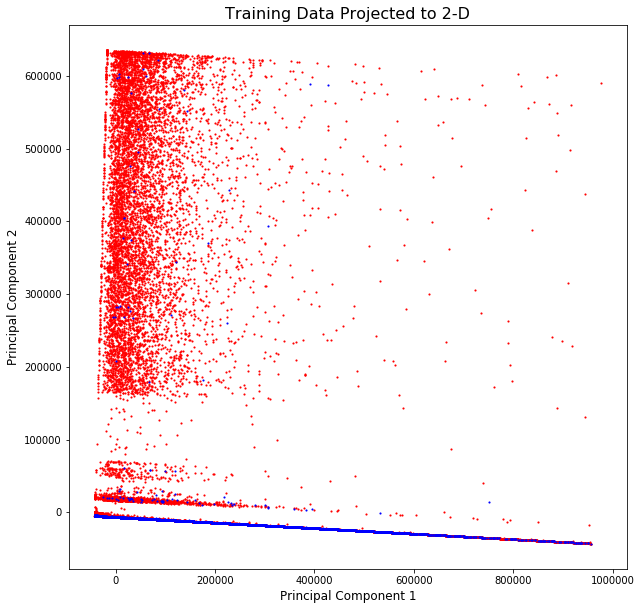

In [11]:
run_2D_PCA(X_train,y_train)

## That does not look quite right, let's try scaling the data.

In [12]:
#normalize
transformer = StandardScaler(copy = False)
X_train = transformer.fit_transform(X_train)
transformer = StandardScaler(copy = False)
X_dev = transformer.fit_transform(X_dev)

## Running classifiers on scaled data

In [13]:
print('Logistic Regression Results:')
run_logistic_regression(X_train,y_train,X_dev,y_dev)
print('Decision Tree Results:')
run_decision_tree(X_train,y_train,X_dev,y_dev)
print('Random Forest Results:')
run_random_forest(X_train,y_train,X_dev,y_dev)
print('XGBoost Results:')
run_XGBoost(X_train,y_train,X_dev,y_dev)

Logistic Regression Results:
AUC ROC: 0.713
[[56927    18]
 [ 1888   221]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56945
           1       0.92      0.10      0.19      2109

    accuracy                           0.97     59054
   macro avg       0.95      0.55      0.59     59054
weighted avg       0.97      0.97      0.96     59054

Decision Tree Results:
AUC ROC: 0.634
[[54185  2760]
 [ 1441   668]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     56945
           1       0.19      0.32      0.24      2109

    accuracy                           0.93     59054
   macro avg       0.58      0.63      0.60     59054
weighted avg       0.95      0.93      0.94     59054

Random Forest Results:
AUC ROC: 0.883
[[56932    13]
 [ 1594   515]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     56945
           1       0.98 

## Run PCA on scaled data

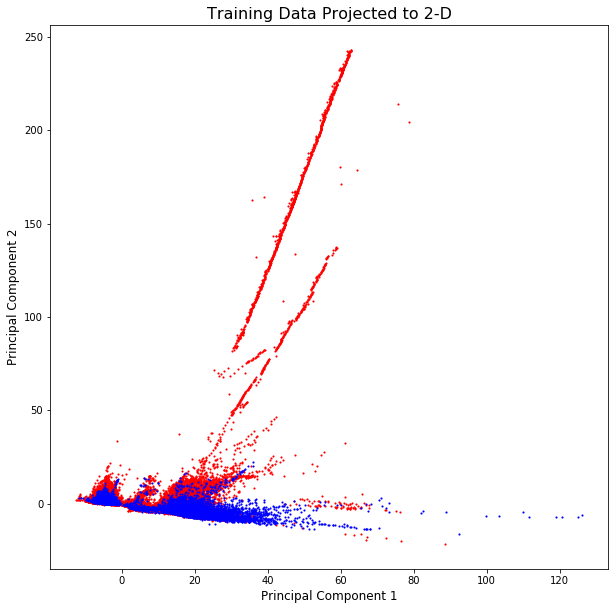

In [14]:
run_2D_PCA(X_train,y_train)

It appears that there is still significant overlap between classes. Let's try plotting not fraud on top of fraud.

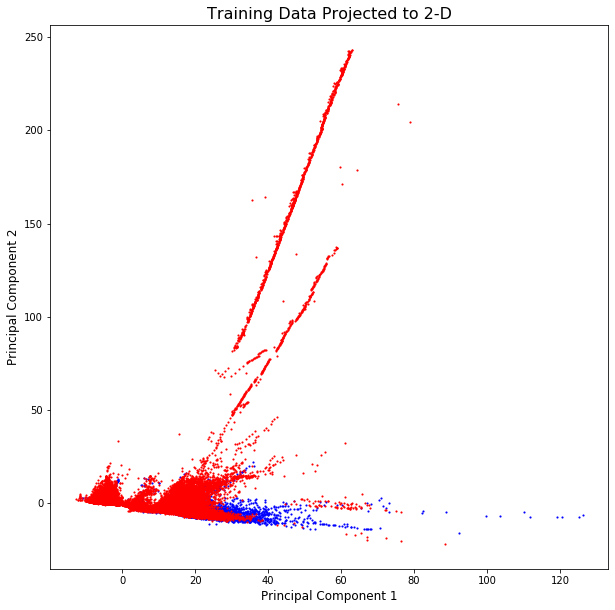

In [16]:
run_2D_PCA(X_train,y_train,invert_classes=True)

## Preparing test data for Kaggle Submission

In [6]:

#bring in train data
train_identity = pd.read_csv('../data/train_identity.csv')
train_transactions = pd.read_csv('../data/train_transaction.csv')
#join train data
train_combined = train_transactions.set_index('TransactionID').join(train_identity.set_index('TransactionID'))
del train_identity, train_transactions

#bring in test data
test_identity = pd.read_csv('../data/test_identity.csv')
test_transactions = pd.read_csv('../data/test_transaction.csv')
#join test data
test_combined = test_transactions.set_index('TransactionID').join(test_identity.set_index('TransactionID'))
del test_identity, test_transactions

#save the test transaction_ids for later
test_indices = test_combined.index

#split off y data from training
y_train = train_combined['isFraud']
train_combined = train_combined.drop(['isFraud'], axis =1)

encoding_types_transaction = {'OneHotEncoder':['ProductCD','card4','card6','M1','M2',\
                                               'M3','M4','M5','M6','M7','M8','M9'],\
                              'LeaveOneOutEncoder': ['P_emaildomain','R_emaildomain','card1',\
                                                     'card2','card3','card5','addr1','addr2']}


encoding_types_identity = {'OneHotEncoder': ['DeviceType','id_12','id_15','id_16','id_23','id_27','id_28',\
                                             'id_29','id_32','id_34','id_35','id_36','id_37','id_38'],\
                           'LeaveOneOutEncoder': ['DeviceInfo','id_13','id_14','id_17','id_18','id_19',\
                                                  'id_20','id_21','id_22','id_24','id_25','id_26','id_30',\
                                                  'id_31','id_33']}

train_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder'],\
                           'LeaveOneOutEncoder' : encoding_types_transaction['LeaveOneOutEncoder'] + encoding_types_identity['LeaveOneOutEncoder']}

dev_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder']}

#drop datetime because it adds const variance
train_combined = train_combined.drop(['TransactionDT'],axis = 1)
test_combined = test_combined.drop(['TransactionDT'],axis = 1)

#encode training data
train_combined = encode_categoricals(train_combined,y_train, train_encoding_types)

# need to fill in 0.5 for all LOO encoded columns in test set
test_combined[train_encoding_types['LeaveOneOutEncoder']] = 0.5

test_combined = encode_categoricals(test_combined,None,dev_encoding_types)

#Need to remove columns that don't exist in test/dev data
shared_cols = train_combined.columns & test_combined.columns

train_combined = train_combined[shared_cols]
test_combined = test_combined[shared_cols]

#impute both datasets with a constant.
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
train_combined = imputer.fit_transform(train_combined)
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
test_combined = imputer.fit_transform(test_combined)

#normalize data
transformer = StandardScaler(copy = False)
train_combined = transformer.fit_transform(train_combined)
transformer = StandardScaler(copy = False)
test_combined = transformer.fit_transform(test_combined)

## Learn and Predict a Random Forest

In [31]:
clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(train_combined, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(test_combined)
print(probs)

[[0.89 0.11]
 [0.94 0.06]
 [0.89 0.11]
 ...
 [0.87 0.13]
 [0.84 0.16]
 [0.87 0.13]]


## Prep for CSV

In [36]:
csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
print(csv_rows[:10])

[['TransactionID', 'isFraud'], [3663549, 0.11], [3663550, 0.06], [3663551, 0.11], [3663552, 0.12], [3663553, 0.12], [3663554, 0.13], [3663555, 0.18], [3663556, 0.14], [3663557, 0.09]]


## Write it to csv for submission

In [37]:
import csv

In [46]:
with open('submission.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Result
![title](img/rf_submission_1.png)

## Dealing with Imbalanced Classes - SMOTE
Given that only a small percentage of our data are fraud (~3.5%) it might be helpful to oversample those cases. Using a technique called SMOTE (Synthetic Minority Oversampling Technique) we can boost the signal of the minority class by creating synthetic datapoints for those cases. Let's bump up our fraud cases to 10%.

In [47]:
smote = SMOTE(random_state = 42,sampling_strategy = 0.1, n_jobs = -1)
X_train_res, y_train_res = smote.fit_resample(train_combined, y_train)
print(X_train_res.shape,y_train_res.shape)

(626864, 493) (626864,)


## Learning and Predicting a Random Forest on oversampled data

In [48]:
clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(X_train_res, y_train_res)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(test_combined)

## Prepping and writing to CSV

In [49]:
csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_smote.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Result
![title](img/rf_submission_2.png)  
Much worse! Maybe we oversampled a little too much. Let's try again with 5% fraud data.

In [52]:
smote = SMOTE(random_state = 42,sampling_strategy = 0.05, n_jobs = -1)
X_train_res, y_train_res = smote.fit_resample(train_combined, y_train)
print(X_train_res.shape,y_train_res.shape)

(598370, 493) (598370,)


In [53]:
clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(X_train_res, y_train_res)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(test_combined)

In [54]:
csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_smote_2.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Result
![title](img/rf_submission_3.png)
Not much better than the first SMOTE attempt. Perhaps there is too much noise here. Let's see how it affected the 2D PCA.

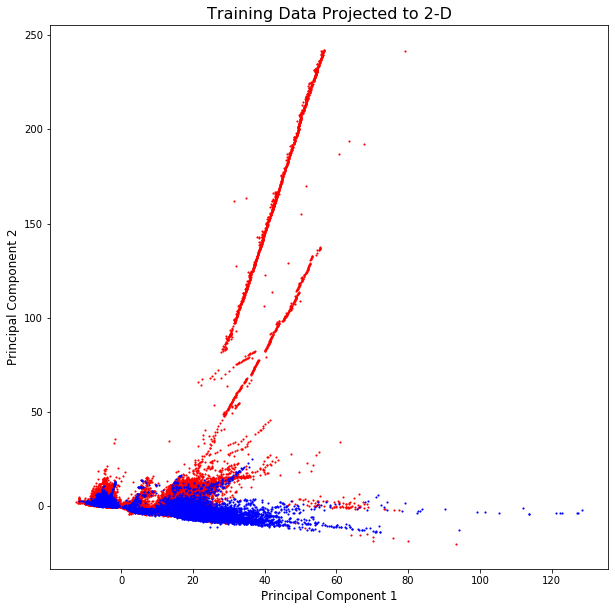

In [55]:
run_2D_PCA(X_train_res, y_train_res)

Given the small amount of added cases, there is not much difference with this one compared to without SMOTE, but there is some fattening of the Fraud (blue) cluster.

## Next Approach: Dimensionality Reduction with PCA
Given that adjusting sample imbalance with SMOTE was ineffective, let's focus on trying to reduce the number of dimensions we are dealing with. We had one pretty successful run, so using that as a baseline, let's find the threshold of dimensions that preserves 99% of the variance and run that through random forest.

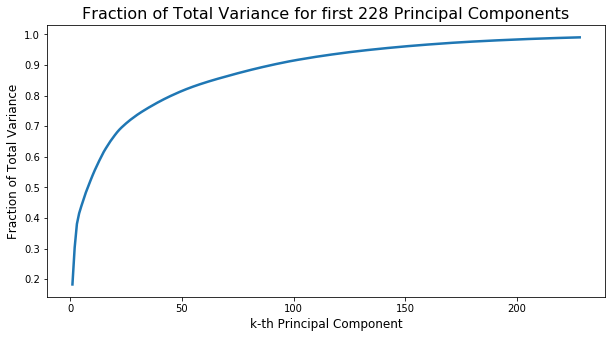

In [11]:
# Data have been processed in the same way as the encoded, simple imputed, and scaled data. 

#look at the principal components:
#initialize PCA
pca = PCA()
#fit PCA to training data
pca_data = pca.fit(train_combined)

#get num of components
nc = pca.components_.shape[0]
    
#generate k values
ks = np.linspace(1,nc,num=nc)
    
#initialize a list to hold cumulate explained variance ratios
evrs = []
ev = 0 #cumulative explained variance
#loop over explained variance ratios for each component of the data
for evr in pca.explained_variance_ratio_:
    #add to cumulative explained variance
    ev += evr
    #add the current cumulatove explained variance to the list
    evrs.append(ev)
    
#find threshold for 99% explained variance
index_counter = 0
for evr in evrs:
    if evr >= 0.99:
        break
    else:
        index_counter += 1

#plot the results.
fig = plt.figure(figsize = (10,5))
plt.plot(ks[:index_counter + 1],evrs[:index_counter + 1],linewidth=2.5)
plt.title('Fraction of Total Variance for first %i Principal Components'%(index_counter + 1),fontsize = 16)
plt.xlabel('k-th Principal Component',fontsize = 12)    
plt.ylabel('Fraction of Total Variance',fontsize = 12)
plt.show()

In [14]:
import csv
#fit train and test data to 228 principal components
#initialize PCA
pca = PCA(n_components = 228)
#fit PCA to training data
pca_data_train = pca.fit_transform(train_combined)
pca_data_test = pca.transform(test_combined)

clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_pca.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Results:
![title](img/rf_submission_4.png)
Not quite as good as the attempt without PCA dimension reduction.

## Next Approach: Dimension Reduction by Eliminating Null Values
In this section, I'll pull out all of the columns that have greater than 75% null values in the training dataset. From there, I will encode, impute, and normalize like previous attempts. Then we can run some random forests on this processed data as well as PCA data.

In [3]:

#bring in train data
train_identity = pd.read_csv('../data/train_identity.csv')
train_transactions = pd.read_csv('../data/train_transaction.csv')
#join train data
train_combined = train_transactions.set_index('TransactionID').join(train_identity.set_index('TransactionID'))
del train_identity, train_transactions

#bring in test data
test_identity = pd.read_csv('../data/test_identity.csv')
test_transactions = pd.read_csv('../data/test_transaction.csv')
#join test data
test_combined = test_transactions.set_index('TransactionID').join(test_identity.set_index('TransactionID'))
del test_identity, test_transactions

#save the test transaction_ids for later
test_indices = test_combined.index

#split off y data from training
y_train = train_combined['isFraud']
train_combined = train_combined.drop(['isFraud'], axis =1)

#find columns with >75% nulls
columns_with_75og_null = []
for col in train_combined.columns:
    num_rows = len(train_combined[col])
    percent_null = train_combined[col].isna().sum() / num_rows
    if percent_null >= 0.75:
        columns_with_75og_null.append(col)
        
#drop columns with lots of nulls
train_combined = train_combined.drop(columns_with_75og_null, axis = 1)
test_combined = test_combined.drop(columns_with_75og_null, axis = 1)

encoding_types_transaction = {'OneHotEncoder':['ProductCD','card4','card6','M1','M2',\
                                               'M3','M4','M5','M6','M7','M8','M9'],\
                              'LeaveOneOutEncoder': ['P_emaildomain','R_emaildomain','card1',\
                                                     'card2','card3','card5','addr1','addr2']}


encoding_types_identity = {'OneHotEncoder': ['DeviceType','id_12','id_15','id_16','id_23','id_27','id_28',\
                                             'id_29','id_32','id_34','id_35','id_36','id_37','id_38'],\
                           'LeaveOneOutEncoder': ['DeviceInfo','id_13','id_14','id_17','id_18','id_19',\
                                                  'id_20','id_21','id_22','id_24','id_25','id_26','id_30',\
                                                  'id_31','id_33']}
#remove null-heavy columns from encoding dict

for col in columns_with_75og_null:
    if col in encoding_types_transaction['OneHotEncoder']:
        encoding_types_transaction['OneHotEncoder'].remove(col)
    elif col in encoding_types_transaction['LeaveOneOutEncoder']:
        encoding_types_transaction['LeaveOneOutEncoder'].remove(col)
    elif col in encoding_types_identity['OneHotEncoder']:
        encoding_types_identity['OneHotEncoder'].remove(col)
    elif col in encoding_types_identity['LeaveOneOutEncoder']:
        encoding_types_identity['LeaveOneOutEncoder'].remove(col)


train_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder'],\
                           'LeaveOneOutEncoder' : encoding_types_transaction['LeaveOneOutEncoder'] + encoding_types_identity['LeaveOneOutEncoder']}

dev_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder']}

#drop datetime because it adds const variance
train_combined = train_combined.drop(['TransactionDT'],axis = 1)
test_combined = test_combined.drop(['TransactionDT'],axis = 1)

#encode training data
train_combined = encode_categoricals(train_combined,y_train, train_encoding_types)

# need to fill in 0.5 for all LOO encoded columns in test set
test_combined[train_encoding_types['LeaveOneOutEncoder']] = 0.5

test_combined = encode_categoricals(test_combined,None,dev_encoding_types)

#Need to remove columns that don't exist in test/dev data
shared_cols = train_combined.columns & test_combined.columns

train_combined = train_combined[shared_cols]
test_combined = test_combined[shared_cols]

#impute both datasets with a constant.
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
train_combined = imputer.fit_transform(train_combined)
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
test_combined = imputer.fit_transform(test_combined)

#normalize data
transformer = StandardScaler(copy = False)
train_combined = transformer.fit_transform(train_combined)
transformer = StandardScaler(copy = False)
test_combined = transformer.fit_transform(test_combined)

In [18]:
clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(train_combined, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(test_combined)
print(probs)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_dimred.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

[[0.93 0.07]
 [0.99 0.01]
 [0.9  0.1 ]
 ...
 [0.91 0.09]
 [0.9  0.1 ]
 [0.81 0.19]]
506692


### Results:
![title](img/rf_submission_5.png)
Slightly better results than our initial data. Lets take a look at the PCA for this reduced dataset.

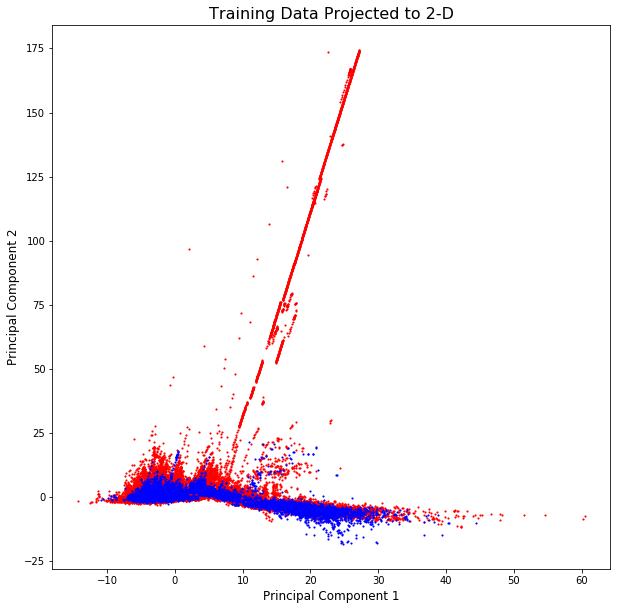

In [20]:
run_2D_PCA(train_combined, y_train)

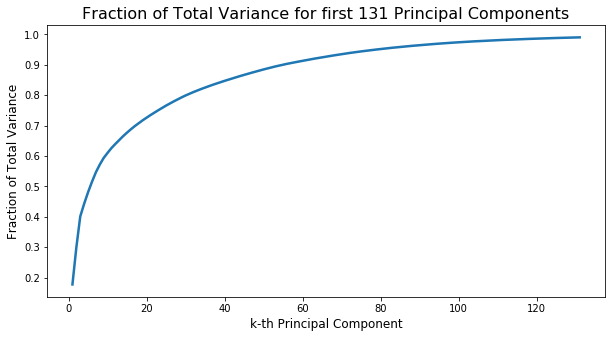

In [21]:
pca = PCA()
#fit PCA to training data
pca_data = pca.fit(train_combined)

#get num of components
nc = pca.components_.shape[0]
    
#generate k values
ks = np.linspace(1,nc,num=nc)
    
#initialize a list to hold cumulate explained variance ratios
evrs = []
ev = 0 #cumulative explained variance
#loop over explained variance ratios for each component of the data
for evr in pca.explained_variance_ratio_:
    #add to cumulative explained variance
    ev += evr
    #add the current cumulatove explained variance to the list
    evrs.append(ev)
    
#find threshold for 99% explained variance
index_counter = 0
for evr in evrs:
    if evr >= 0.99:
        break
    else:
        index_counter += 1

#plot the results.
fig = plt.figure(figsize = (10,5))
plt.plot(ks[:index_counter + 1],evrs[:index_counter + 1],linewidth=2.5)
plt.title('Fraction of Total Variance for first %i Principal Components'%(index_counter + 1),fontsize = 16)
plt.xlabel('k-th Principal Component',fontsize = 12)    
plt.ylabel('Fraction of Total Variance',fontsize = 12)
plt.show()

A little more than half of the dimensions explain 99% of the variance than the previous attempt. Let's try running PCA data through the classifier.

In [22]:
#initialize PCA
pca = PCA(n_components = 131)
#fit PCA to training data
pca_data_train = pca.fit_transform(train_combined)
pca_data_test = pca.transform(test_combined)

clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_pca_2.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Results:
![title](img/rf_submission_6.png)
Similar to our other PCA submission.

## Next Classifier: XG Boost
The two most recent scores were pretty good. Lets try another classifier, XG Boost.

In [24]:
clf = XGBClassifier(random_state=42,n_jobs=10,n_estimators=100).fit(train_combined, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(test_combined)
print(probs)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_dimred_XGBoost.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

[[0.9814893  0.01851071]
 [0.9623385  0.03766151]
 [0.92211616 0.07788382]
 ...
 [0.89678466 0.10321536]
 [0.8777277  0.12227231]
 [0.8963442  0.10365579]]
506692


### Results:
![title](img/xgboost_submission_1.png)
Similar to our Random Forest Submission. Let's try it on PCA data.

In [25]:
clf = XGBClassifier(random_state=42,n_jobs=10,n_estimators=100).fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)
print(probs)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_pca_XGBoost.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

[[0.9859526  0.01404736]
 [0.98842436 0.01157564]
 [0.962407   0.03759298]
 ...
 [0.9832402  0.01675983]
 [0.974768   0.02523201]
 [0.97553235 0.02446765]]
506692


### Results:
![title](img/xgboost_submission_2.png)
Similar to our Random Forest Submission on PCA data.

## Let's try some logistic regression

In [5]:
# Try logisitic regression on scaled, null column-removed data
clf = LogisticRegression(penalty = 'l2', tol = 0.01, random_state=42, solver = 'saga').fit(train_combined, y_train)
probs = clf.predict_proba(test_combined)

#write results to CSV
csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])

with open('submission_logreg_1.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Results:
![title](img/logreg_submission_1.png)
Not bad, but not as good as other classifiers tried. Let's see if it gets any better using PCA data.

In [6]:
#initialize PCA
pca = PCA(n_components = 131)
#fit PCA to training data
pca_data_train = pca.fit_transform(train_combined)
pca_data_test = pca.transform(test_combined)

clf = LogisticRegression(penalty = 'l2', tol = 0.01, random_state=42, solver = 'saga').fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_logreg_pca.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692


### Results:
![title](img/logreg_submission_2.png)
About the same as logisitic regression on non-PCA data.
Finally, lets test some single decision trees on non-PCA and PCA data.
## Decision Trees

In [7]:
clf = DecisionTreeClassifier(random_state=42, criterion = 'gini').fit(train_combined, y_train)
probs = clf.predict_proba(test_combined)

#write results to CSV
csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])

with open('submission_dt_gini.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)
    
clf = DecisionTreeClassifier(random_state=42, criterion = 'gini').fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_dt_gini_pca.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692
506692


### Results:
**Non-PCA Data**
![title](img/dt_submission_1.png)
Worse than our initial results with little pre-processing.  
  
**PCA Data**
![title](img/dt_submission_2.png)
Still not great. Would using a different splitting criterion be helpful?

In [8]:
clf = DecisionTreeClassifier(random_state=42, criterion = 'entropy').fit(train_combined, y_train)
probs = clf.predict_proba(test_combined)

#write results to CSV
csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])

with open('submission_dt_entropy.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)
    
clf = DecisionTreeClassifier(random_state=42, criterion = 'entropy').fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_dt_entropy_pca.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)

506692
506692


### Results:
**Non-PCA Data**
![title](img/dt_submission_3.png)
  
**PCA Data**
![title](img/dt_submission_4.png)
  
Entropy clearly is not doing us any favors here.  
## Finally, let's try some other pre-processing  
No one-hot encoding here, just Leave-One-Out

In [9]:
#bring in train data
train_identity = pd.read_csv('../data/train_identity.csv')
train_transactions = pd.read_csv('../data/train_transaction.csv')
#join train data
train_combined = train_transactions.set_index('TransactionID').join(train_identity.set_index('TransactionID'))
del train_identity, train_transactions

#bring in test data
test_identity = pd.read_csv('../data/test_identity.csv')
test_transactions = pd.read_csv('../data/test_transaction.csv')
#join test data
test_combined = test_transactions.set_index('TransactionID').join(test_identity.set_index('TransactionID'))
del test_identity, test_transactions

#save the test transaction_ids for later
test_indices = test_combined.index

#split off y data from training
y_train = train_combined['isFraud']
train_combined = train_combined.drop(['isFraud'], axis =1)

#find columns with >75% nulls
columns_with_75og_null = []
for col in train_combined.columns:
    num_rows = len(train_combined[col])
    percent_null = train_combined[col].isna().sum() / num_rows
    if percent_null >= 0.75:
        columns_with_75og_null.append(col)
        
#drop columns with lots of nulls
train_combined = train_combined.drop(columns_with_75og_null, axis = 1)
test_combined = test_combined.drop(columns_with_75og_null, axis = 1)

encoding_types_transaction = {'LeaveOneOutEncoder':['ProductCD','card4','card6','M1','M2',\
                                               'M3','M4','M5','M6','M7','M8','M9',\
                                                    'P_emaildomain','R_emaildomain','card1',\
                                                     'card2','card3','card5','addr1','addr2']}


encoding_types_identity = {'LeaveOneOutEncoder': ['DeviceType','id_12','id_15','id_16','id_23','id_27','id_28',\
                                             'id_29','id_32','id_34','id_35','id_36','id_37','id_38', \
                                                  'DeviceInfo','id_13','id_14','id_17','id_18','id_19',\
                                                  'id_20','id_21','id_22','id_24','id_25','id_26','id_30',\
                                                  'id_31','id_33']}
#remove null-heavy columns from encoding dict

for col in columns_with_75og_null:
    if col in encoding_types_transaction['LeaveOneOutEncoder']:
        encoding_types_transaction['LeaveOneOutEncoder'].remove(col)
    elif col in encoding_types_identity['LeaveOneOutEncoder']:
        encoding_types_identity['LeaveOneOutEncoder'].remove(col)


train_encoding_types = {'LeaveOneOutEncoder' : encoding_types_transaction['LeaveOneOutEncoder'] + encoding_types_identity['LeaveOneOutEncoder']}

#dev_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder']}

#drop datetime because it adds const variance
train_combined = train_combined.drop(['TransactionDT'],axis = 1)
test_combined = test_combined.drop(['TransactionDT'],axis = 1)

#encode training data
train_combined = encode_categoricals(train_combined,y_train, train_encoding_types)

# need to fill in 0.5 for all LOO encoded columns in test set
test_combined[train_encoding_types['LeaveOneOutEncoder']] = 0.5

#test_combined = encode_categoricals(test_combined,None,dev_encoding_types)

#Need to remove columns that don't exist in test/dev data
shared_cols = train_combined.columns & test_combined.columns

train_combined = train_combined[shared_cols]
test_combined = test_combined[shared_cols]

#impute both datasets with a constant.
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
train_combined = imputer.fit_transform(train_combined)
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
test_combined = imputer.fit_transform(test_combined)

#normalize data
transformer = StandardScaler(copy = False)
train_combined = transformer.fit_transform(train_combined)
transformer = StandardScaler(copy = False)
test_combined = transformer.fit_transform(test_combined)

#initialize PCA
pca = PCA(n_components = 131)
#fit PCA to training data
pca_data_train = pca.fit_transform(train_combined)
pca_data_test = pca.transform(test_combined)

In [11]:
clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(train_combined, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(test_combined)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_rf_loo.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)
'''
clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(pca_data_train, y_train)
#predictions = clf.predict(test_combined)
probs = clf.predict_proba(pca_data_test)

csv_rows = [['TransactionID', 'isFraud']]
for i in range(len(test_indices)):
    csv_rows.append([test_indices[i],probs[i][1]])
    
with open('submission_rf_loo_pca.csv', 'w') as file:
    writer = csv.writer(file)
    counter = 0
    for row in csv_rows:
        writer.writerow(row)
        counter += 1
    print(counter)
'''

506692


"\nclf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(pca_data_train, y_train)\n#predictions = clf.predict(test_combined)\nprobs = clf.predict_proba(pca_data_test)\n\ncsv_rows = [['TransactionID', 'isFraud']]\nfor i in range(len(test_indices)):\n    csv_rows.append([test_indices[i],probs[i][1]])\n    \nwith open('submission_rf_loo_pca.csv', 'w') as file:\n    writer = csv.writer(file)\n    counter = 0\n    for row in csv_rows:\n        writer.writerow(row)\n        counter += 1\n    print(counter)\n"

### Results:
**Non-PCA Data**
![title](img/rf_submission_8.png)
  
**PCA Data**
![title](img/rf_submission_7.png)
  